In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from stellargraph import StellarGraph
from stellargraph.datasets import Cora, CiteSeer, PubMedDiabetes

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from scipy import linalg
from scipy.spatial.distance import pdist, squareform
import scipy.sparse as sp
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import coo_matrix

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical

from IPython.display import display, HTML

In [7]:
def spectral_clustering(adjacency_matrix, labels, laplacian, number_of_clusters):
    
    degree_vector = np.array(adjacency_matrix.sum(axis=1)).flatten()

    # if laplacian == "sym":

    #     # Normalized Symmetric laplacian matrix
    #     d_half = sp.diags(1.0 / np.sqrt(degree_vector))
    #     laplacian_matrix_normalized = d_half @ adjacency_matrix @ d_half
        
    # if laplacian == "rw":

    #     # Normalized Random Walk laplacian matrix
    #     d_inverse = sp.diags(1.0 / degree_vector)
    #     laplacian_matrix_normalized = d_inverse @ adjacency_matrix

    # if laplacian == "ad":
        
    #     # Adaptive Laplacian matrix
    #     D_local = np.zeros_like(degree_vector)
        
    #     for i in range(len(degree_vector)):
    #         neighbors = adjacency_matrix[i].nonzero()[1]
    #         if len(neighbors) > 0:
    #             D_local[i] = adjacency_matrix[neighbors].sum() / degree_vector[i]
    #         else:
    #             D_local[i] = 0
        
    #     D_local_inv = sp.diags(1.0 / np.sqrt(D_local))
    #     laplacian_matrix_normalized = D_local_inv @ adjacency_matrix @ D_local_inv

    if laplacian == "sym":

        # Normalized Symmetric Laplacian matrix
        d_inv_sqrt = np.zeros_like(degree_vector, dtype=float)
        nonzero = degree_vector > 0
        d_inv_sqrt[nonzero] = 1.0 / np.sqrt(degree_vector[nonzero])
        # Create sparse diagonal matrix
        d_half = sp.diags(d_inv_sqrt)
        laplacian_matrix_normalized = d_half @ adjacency_matrix @ d_half
    
    elif laplacian == "rw":
    
        # Normalized Random Walk Laplacian matrix
        d_inv = np.zeros_like(degree_vector, dtype=float)
        nonzero = degree_vector > 0
        d_inv[nonzero] = 1.0 / degree_vector[nonzero]
        # Create sparse diagonal matrix
        d_inverse = sp.diags(d_inv)
        laplacian_matrix_normalized = d_inverse @ adjacency_matrix
    
    elif laplacian == "ad":
    
        # Adaptive Laplacian matrix
        D_local = np.zeros_like(degree_vector, dtype=float)
        for i in range(len(degree_vector)):
            neighbors = adjacency_matrix[i].nonzero()[1]
            if len(neighbors) > 0 and degree_vector[i] > 0:
                D_local[i] = degree_vector[neighbors].sum() / degree_vector[i]
            else:
                D_local[i] = 0.0
        D_local_inv_sqrt = np.zeros_like(D_local, dtype=float)
        nonzero = D_local > 0
        D_local_inv_sqrt[nonzero] = 1.0 / np.sqrt(D_local[nonzero])
        # Create sparse diagonal matrix
        D_local_inv = sp.diags(D_local_inv_sqrt)
        laplacian_matrix_normalized = D_local_inv @ adjacency_matrix @ D_local_inv

    laplacian_matrix_normalized_densed = laplacian_matrix_normalized.toarray()

    if check_symmetric(laplacian_matrix_normalized_densed) :
        # Calculating eigenvalues and eigenvectors for symmetric matrix
        e, v = np.linalg.eigh(laplacian_matrix_normalized_densed)
    else:
        # Calculating eigenvalues and eigenvectors for non-symmetric matrix
        e, v = np.linalg.eig(laplacian_matrix_normalized_densed)
        idx = np.argsort(np.real(e))
        e = np.real(e[idx])
        v = np.real(v[:, idx]) 
    
    # Calculate eigengap
    eigengap = np.diff(e)
    optimal_number_of_clusters = np.argmax(eigengap[:10]) + 1   

    if number_of_clusters != None:
        # First case: k
        n_clusters = max(number_of_clusters,2)
        X = v[:, -n_clusters:]
    else:
        # Second case: optimal number of clusters from eigengap
        n_clusters = max(optimal_number_of_clusters,2)
        X = v[:, -n_clusters:]
    
    results = []

    # KMeans clustering
    clustering = KMeans(n_clusters=n_clusters, random_state=42, n_init=100)
    cluster_labels = clustering.fit_predict(X)
    
    sil_score = silhouette_score(X, cluster_labels)
    ar_score = adjusted_rand_score(labels, cluster_labels)

    results.append((sil_score, ar_score, n_clusters,cluster_labels))

    return results

In [8]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [ ]:
def load_nodes(nodes_file):
    # Read the nodes CSV file
    node_data = pd.read_csv(nodes_file)
    
    # Extract labels
    labels = node_data['label'].values
    
    # Extract features if needed
    features_list = node_data['features'].apply(eval).tolist()
    feature_matrix = np.array(features_list)
    
    return labels, feature_matrix

def load_edges(edges_file, num_nodes):
    # Read the edges CSV file
    edge_list = pd.read_csv(edges_file)
    
    # Extract source and target node IDs
    source_ids = edge_list['source_id'].values
    target_ids = edge_list['target_id'].values
    
    # Create the adjacency matrix as a sparse matrix
    adjacency_matrix = sp.coo_matrix(
        (np.ones(len(source_ids)), (source_ids, target_ids)),
        shape=(num_nodes, num_nodes)
    )
    
    # If the graph is undirected, make the adjacency matrix symmetric
    adjacency_matrix = adjacency_matrix + adjacency_matrix.T
    adjacency_matrix.data = np.clip(adjacency_matrix.data, 0, 1)  # Ensure binary entries
    
    # Convert to CSR format for efficient arithmetic operations
    adjacency_matrix = adjacency_matrix.tocsr()
    
    return adjacency_matrix

def load_data_from_csv(nodes_file, edges_file):
    # Load labels and features
    labels, feature_matrix = load_nodes(nodes_file)
    
    # Number of nodes
    num_nodes = len(labels)
    
    # Load adjacency matrix
    adjacency_matrix = load_edges(edges_file, num_nodes)
    
    return adjacency_matrix, labels, feature_matrix

adjacency_matrix, labels, feature_matrix = load_data_from_csv("nodes.csv","edges.csv")

In [9]:
laplacian_methods = ["sym", "rw","ad"]
silhouette_scores = []
adjusted_rand_scores = []
adjusted_mutual_info_scores = []
clusters = []
laplacian = []
cluster_labels = []

/Users/evi/.pyenv/versions/3.8.14/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [10]:
for laplace in laplacian_methods:
    metrics = spectral_clustering(adjacency_matrix, labels, laplace, 7)
    
    for si, ar, cl,l in metrics:
        laplacian.append(laplace)
        
        silhouette_scores.append(si)
        adjusted_rand_scores.append(ar)
        clusters.append(cl)
        cluster_labels.append(l)

In [11]:
experiment_cora = pd.DataFrame(list(zip(laplacian,silhouette_scores,adjusted_rand_scores,clusters)), 
             columns= ["laplacian", "silhouette", "adjusted_rand","clusters"])

experiment_cora

,laplacian,silhouette,adjusted_rand,clusters
0,sym,0.984967,0.001031,7
1,rw,0.988270,0.008627,7
2,ad,0.995747,-0.001565,7


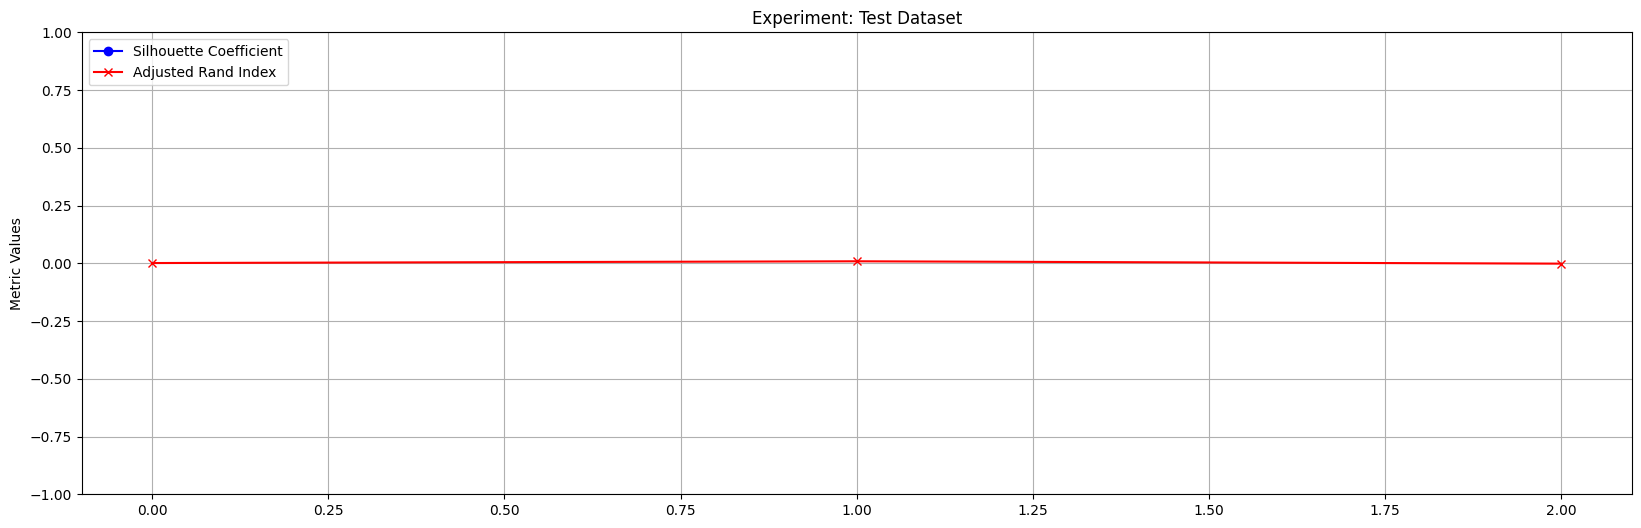

In [13]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 6))

# Define an offset to avoid overlap
offset = 0.05

# Plot silhouette coefficient with an offset
ax.plot(experiment_cora['silhouette'] + offset, 
        marker='o', color='b', label='Silhouette Coefficient', markersize=6)

# Plot Adjusted Rand Index with an offset
ax.plot(experiment_cora['adjusted_rand'], 
        marker='x', color='r', label='Adjusted Rand Index', markersize=6)

# Set labels
ax.set_ylabel('Metric Values')

# Adjust y-axis limits dynamically
ax.set_ylim(-1, 1)  # Set limits to fit the offsets

# Add a title
plt.title('Experiment: Test Dataset')

# Add a legend
ax.legend(loc='upper left')

# Show grid for better readability
plt.grid()

# Show the plot
plt.show()